# SUPPOSe-Langevin Reconstruction (ifftshift, 10000 pasos)

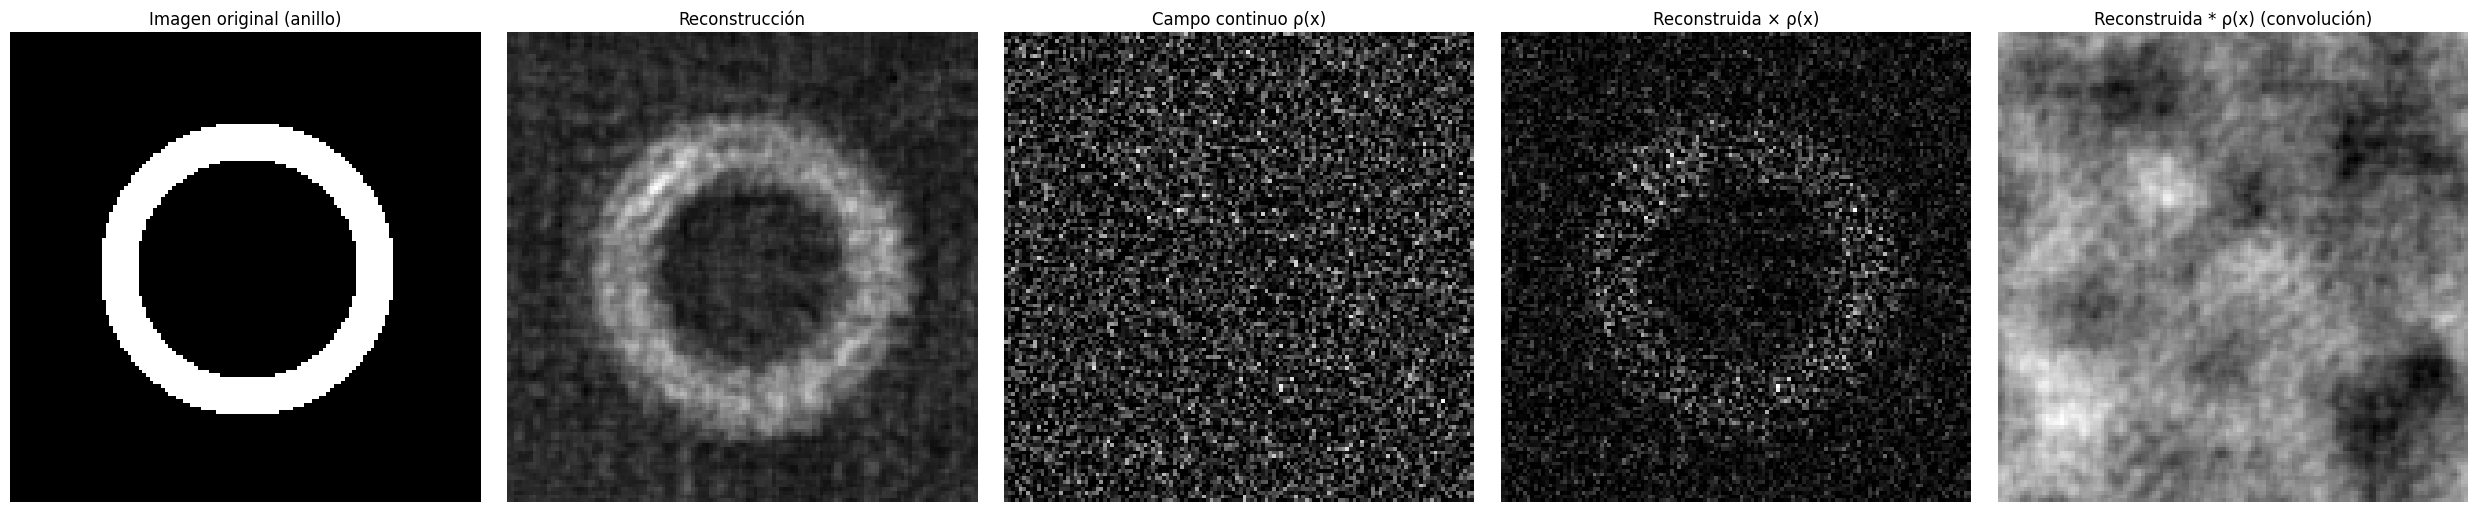

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, ifftshift
from skimage.draw import disk

# Crear imagen de anillo
def generar_anillo(shape=(128, 128), radio_ext=40, grosor=10):
    imagen = np.zeros(shape, dtype=np.float32)
    centro = (shape[0] // 2, shape[1] // 2)
    rr_out, cc_out = disk(centro, radio_ext)
    rr_in, cc_in = disk(centro, radio_ext - grosor)
    imagen[rr_out, cc_out] = 1.0
    imagen[rr_in, cc_in] = 0.0
    return imagen

# PSF
def generate_psf_kernel(sigma=2.0):
    size = int(6 * sigma)
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def pad_kernel_to_image(kernel, shape):
    padded = np.zeros(shape, dtype=np.float32)
    k_shape = kernel.shape
    insert_slice = tuple(
        slice((s - ks) // 2, (s - ks) // 2 + ks) for s, ks in zip(shape, k_shape)
    )
    padded[insert_slice] = kernel
    return padded

# Parámetros
image_size = 128
padded_size = image_size * 4
offset = (padded_size - image_size) // 2
steps_field = 20000
T0_field = 1.0
tau_field = steps_field / 1.0
lambda_smooth = 0.2
mu_entropy = 0.01
epsilon_rho = 0.01
psf_sigma = 2.0
np.random.seed(42)

# Imagen anillo
true_image = generar_anillo((image_size, image_size))
image_padded = np.zeros((padded_size, padded_size), dtype=np.float32)
image_padded[offset:offset + image_size, offset:offset + image_size] = true_image

# PSF
psf_kernel = generate_psf_kernel(psf_sigma)
psf_kernel_shifted = ifftshift(psf_kernel)
kernel_padded = pad_kernel_to_image(psf_kernel_shifted, (padded_size, padded_size))
kernel_fft_padded = fft2(kernel_padded)

# Campo inicial
rho_padded = np.abs(np.random.rand(padded_size, padded_size)) * 0.1

# Evolución tipo Langevin
for step in range(steps_field):
    T_t = T0_field * np.exp(-step / tau_field)
    recon = np.real(ifft2(fft2(rho_padded) * kernel_fft_padded))
    residual = recon - image_padded
    d_chi2 = 2 * np.real(ifft2(fft2(residual) * kernel_fft_padded))
    laplacian = -4 * rho_padded + np.roll(rho_padded, 1, axis=0) + np.roll(rho_padded, -1, axis=0) +                 np.roll(rho_padded, 1, axis=1) + np.roll(rho_padded, -1, axis=1)
    d_smooth = -2 * lambda_smooth * laplacian
    d_entropy = mu_entropy * (1 + np.log(rho_padded + 1e-8))
    delta_S = d_chi2 + d_smooth + d_entropy
    noise = np.random.normal(0, 1, rho_padded.shape)
    rho_padded -= epsilon_rho * delta_S + np.sqrt(2 * epsilon_rho * T_t) * noise
    rho_padded = np.clip(rho_padded, 0, None)

# Recortes
final_rho = rho_padded[offset:offset + image_size, offset:offset + image_size]
final_recon = np.real(ifft2(fft2(rho_padded) * kernel_fft_padded))[offset:offset + image_size, offset:offset + image_size]

# Producto y convolución entre reconstruida y rho
product_recon_rho = final_recon * final_rho
conv_recon_rho = np.real(ifft2(fft2(final_recon) * fft2(final_rho)))
center = conv_recon_rho.shape[0] // 2
half = image_size // 2
conv_recon_rho_cropped = conv_recon_rho[center - half:center + half, center - half:center + half]

# Visualización
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
axs[0].imshow(true_image, cmap='gray')
axs[0].set_title("Imagen original (anillo)")
axs[0].axis('off')

axs[1].imshow(final_recon, cmap='gray')
axs[1].set_title("Reconstrucción")
axs[1].axis('off')

axs[2].imshow(final_rho, cmap='gray')
axs[2].set_title("Campo continuo ρ(x)")
axs[2].axis('off')

axs[3].imshow(product_recon_rho, cmap='gray')
axs[3].set_title("Reconstruida × ρ(x)")
axs[3].axis('off')

axs[4].imshow(conv_recon_rho_cropped, cmap='gray')
axs[4].set_title("Reconstruida * ρ(x) (convolución)")
axs[4].axis('off')

plt.tight_layout()
plt.show()
